In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import demoji

In [52]:
train_df = pd.read_csv("../datasets/train/train_emoticon.csv")
val_df = pd.read_csv("../datasets/valid/valid_emoticon.csv")
test_df = pd.read_csv("../datasets/test/test_emoticon.csv")

In [46]:
def get_char_columns(df):
    for i in range(len(df['input_emoticon'][0])):
        df[f'c_{i+1}'] = df['input_emoticon'].apply(lambda x: x[i])
    columns = df.columns.to_list()
    columns = columns[2:]
    columns += ['label']
    
    return df[columns]

In [54]:
train_df = get_char_columns(train_df)
val_df = get_char_columns(val_df)

## Approach 1 : Emoji to Text to BERT Embedding

In [56]:
for i in range(13) :
    train_df[f'c_{i+1}_text'] = train_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)
    val_df[f'c_{i+1}_text'] = val_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)

In [57]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [58]:
def text2embed(text) :
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1)

    return sentence_embedding.numpy().reshape(-1)

In [59]:
texts = []
for i in range(13) :
    for text in train_df[f'c_{i+1}_text'] :
        texts.append(text)
texts = list(set(texts))

In [60]:
dict_text2bed = {f'{text}' : text2embed(text) for text in texts}

In [61]:
def embed_df(df : pd.DataFrame, embedding_dim : int = 768, num_columns: int = 13)-> pd.DataFrame :

    # Initialize a list to store rows of combined embeddings
    combined_embeddings = []

    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        row_embeddings = []
        
        # Iterate over the 13 columns and get the embedding for each
        for i in range(num_columns):
            column_text = row[f'c_{i+1}_text']
            
            # If the text is not empty, fetch its embedding, else use a zero vector
            if column_text != '':
                embedding = dict_text2bed.get(column_text, np.zeros(embedding_dim))
            else:
                embedding = np.zeros(embedding_dim)
            
            # Append the embedding to the row list
            row_embeddings.append(embedding)
        
        # Concatenate the embeddings for the row
        combined_embeddings.append(np.hstack(row_embeddings))

    # Convert the list of rows into a NumPy array
    X = np.vstack(combined_embeddings)
    
    return X



In [62]:
X_train = embed_df(train_df)
y_train = train_df['label']

X_val = embed_df(val_df)
y_val = val_df['label']

## Approach 2 : Emoji to Embedding directly

## XGBOOST

In [3]:
from xgboost import XGBClassifier

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

NameError: name 'X_train' is not defined

In [67]:
X_train.shape, y_train.shape

((7080, 9984), (7080,))

In [68]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/home/arush-upadhyaya/anaconda3/envs/771/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:30:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=cmap)
    plt.show()

def get_classification_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])

In [71]:
y_pred = xgb_model.predict(X_val)


              precision    recall  f1-score   support

     Class 0       0.83      0.73      0.78       252
     Class 1       0.75      0.84      0.79       237

    accuracy                           0.79       489
   macro avg       0.79      0.79      0.79       489
weighted avg       0.79      0.79      0.79       489



In [ ]:
report = get_classification_report(y_val, y_pred)
print(report)

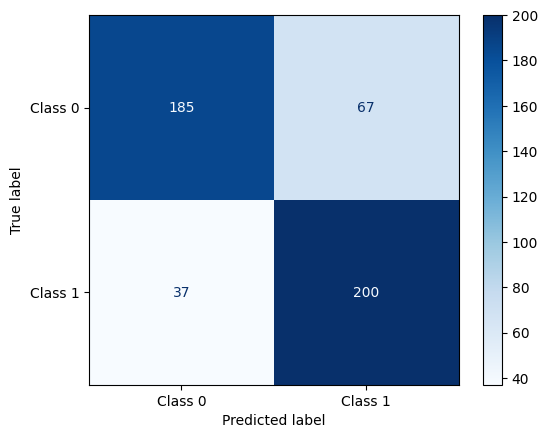

In [72]:
plot_confusion_matrix(y_val, y_pred, classes = ['Class 0', 'Class 1'], title='Train Confusion Matrix')

In [73]:
accuracy_score(y_val,y_pred)

0.787321063394683